# Complex Precoding LMMSE Pytorch Paper, 06.04.2023

In [1]:
import math
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp
from scipy.stats import gmean
from scipy.io import loadmat
from scipy.optimize import minimize, minimize_scalar, root
from scipy.optimize import NonlinearConstraint

from time import time
from glob import glob
from bisect import bisect
from functools import partial
from collections import defaultdict, deque
from sklearn.utils import resample
from statistics import mean, stdev
from tqdm.notebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(9.7,6.27)}, style="whitegrid", font_scale=1.2)

In [2]:
# H (n_users, n_layers, n_antennas)
# W (n_antennas, n_users, n_ranks)

In [3]:
beta_table = torch.tensor([[1.60, 1.60],
                  [1.61, 1.63],
                  [1.63, 1.67],
                  [1.65, 1.73],
                  [1.67, 1.79],
                  [1.70, 4.27],
                  [1.73, 4.71],
                  [1.76, 5.16],
                  [1.79, 5.66],
                  [1.82, 6.16],
                  [3.97, 6.50],
                  [4.27, 10.97],
                  [4.71, 12.92],
                  [5.16, 14.96],
                  [5.66, 17.06],
                  [6.16, 19.33],
                  [6.50, 21.85],
                  [9.95, 24.51],
                  [10.97, 27.14],
                  [12.92, 29.94],
                  [14.96, 56.48],
                  [17.06, 65.00],
                  [19.33, 78.58],
                  [21.85, 92.48],
                  [24.51, 106.27],
                  [27.14, 118.74],
                  [29.94, 126.36],
                  [32.05, 132.54]])

eff_sinr_table = torch.exp2(torch.tensor([(0.2344, 0.2344),
                                         (0.3066, 0.377),
                                         (0.377, 0.6016),
                                         (0.4902, 0.877),
                                         (0.6016, 1.1758),
                                         (0.7402, 1.4766),
                                         (0.877, 1.6953),
                                         (1.0273, 1.9141),
                                         (1.1758, 2.1602),
                                         (1.3262, 2.4063),
                                         (1.3281, 2.5703),
                                         (1.4766, 2.7305),
                                         (1.6953, 3.0293),
                                         (1.9141, 3.3223),
                                         (2.1602, 3.6094),
                                         (2.4063, 3.9023),
                                         (2.5703, 4.2129),
                                         (2.5703, 4.5234),
                                         (2.7305, 4.8164),
                                         (3.0293, 5.1152),
                                         (3.3223, 5.332),
                                         (3.6094, 5.5547),
                                         (3.9023, 5.8906),
                                         (4.2129, 6.2266),
                                         (4.5234, 6.5703),
                                         (4.8164, 6.9141),
                                         (5.1152, 7.1602),
                                         (5.332, 7.4063)])) - 1

#2.5664

In [4]:
def lin2db(x):
    """ Map linear scale to the logarithmic db """
    return 10 * np.log10(x)

def db2lin(x):
    """ Map logarithmic db to the linear scale """
    return 10 ** (x / 10)
    
def zero_forcing(V):
    """ Zero Forcing precoding in its native implementation """
    return V.solve(V @ V.conj().t())[0].conj().t()

def regularized(V, R):
    """ Regularization with inversed squared singular values """
    return V.solve(V @ V.conj().t() + V.shape[0] * torch.eye(V.shape[0]) * R)[0].conj().t()

def normalize_precoding(W):
    """ Make feasible per antenna power with equalization """
    T = W / W.norm(dim=0)
    return T / T.norm(dim=1).max() / T.shape[0] ** 0.5

def normalize_max_antennas(W):
    """ Make feasible per antenna power with equalization """
    return W / W.norm(dim=1).max() / W.shape[0] ** 0.5

def tgmean(input_x, dim):
    """ Differentiable Torch Geometric Mean """
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

def su_sinr(S, s):
    return lin2db(gmean(S.reshape(-1, n_ranks) ** 2, axis=1) / (n_ranks * s ** 2)).mean()

def spectral_efficiency(H, W, s):
    """ Score function is applied for torch complex tensors """
    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    K = B.permute(0, 2, 1).conj() @ B + torch.eye(B.shape[2]) * s ** 2
    
    G = B.permute(0, 2, 1).conj().solve(K)[0]
    G = torch.block_diag(*G)
    
    A = (G @ H.reshape(-1, n_antennas) @ W).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(dim=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def irc_detection(H, W, s):
    """ IRC Detection Matrix """
    X = H.reshape(-1, n_antennas) @ W
    Y = X.reshape(n_users, n_layers, n_users, n_ranks)
    Z = Y.permute(0, 2, 1, 3) @ Y.permute(0, 2, 3, 1).conj()
    J = Z.permute(0, 2, 1, 3).reshape([n_users * n_layers] * 2)

    R = J.reshape(n_users, n_layers, n_users, n_layers).sum(dim=2)
    Q = torch.eye(R.shape[1]) * s ** 2

    B = H @ W.reshape(-1, n_users, n_ranks).permute(1, 0, 2)
    G = B.solve(R + Q)[0].permute(0, 2, 1).conj()
    G = torch.block_diag(*G)
    return G, X

def spectral_efficiency_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return (1 + L).log2().mean() * n_ranks

def mu_sinr_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return lin2db(L).mean()

def ideal_efficience(V, W, R):
    """ Score function is applied for torch complex tensors
            sum_k (log (sum_l |<v_k, w_l>|^2 + s^2) - 
                        log (sum_{l\k} |<v_k, w_l>|^2 + s^2)) 
    """
    A = V @ W
    B = (A * A.conj()).real
    N = B.sum(dim=1) + R
    D = N - B.diag()
    L = N.log2() - D.log2()
    return L.mean() * n_ranks

def quantize_precoding(W, N):
    def quantize(X, N):
        return (X / X.abs().max() * N).round()
    return torch.complex(quantize(W.real, N), quantize(W.imag, N))

def calc_corr(C):
    return ((np.abs(C @ C.conj().T) - np.eye(C.shape[0])) ** 2).mean()

def fbs_fame_loss(V, W, gamma=1.1):
    return (V @ W).norm() ** 2 - gamma * ((V.conj().t() * W).sum(dim=0).abs() ** 2).sum()

def fbs_fame_score(V, W, gamma=1.1):
    return gamma * ((V.conj().t() * W).sum(dim=0).abs() ** 2).sum() - (V @ W).norm() ** 2

def fbs_fame_prox(W, nu=1.1):
    def prox(X, eps, nu):
        return (nu * X).clamp(-eps, eps)
    eps = 1 / (2 * W.shape[0]) ** 0.5
    return torch.complex(prox(W.real, eps, nu), prox(W.imag, eps, nu))

def generate_channel(n_users, n_layers, n_antennas):
    """ Sample channel matrix H from the complex normal distribution CN(0, I) """
    return np.random.randn(n_users, n_layers, n_antennas, 2).view(complex).squeeze() / 2 ** 0.5

# Algorithms

In [5]:
from collections.abc import Sequence

class FlyingSuSinr(Sequence):
    def __init__(self, S, s_grid):
        """Construct a lazy sequence representation"""
        self.s_grid = s_grid
        self.n = len(self.s_grid)
        self.sinr = partial(su_sinr, S)
    def __len__(self):
        return self.n
    def __getitem__(self, i):
        if not (0 <= i < self.n):
            raise IndexError
        return self.sinr(self.s_grid[i])

In [6]:
def find_mcses(sinr_eff, qam_mode):
    x = sinr_eff >= eff_sinr_table[:, qam_mode, np.newaxis]
    x[0, :] = torch.ones(1, sinr_eff.shape[0], dtype=bool)
    return torch.nonzero(torch.diff(x, 
        append=torch.zeros(1, sinr_eff.shape[0], dtype=bool), dim=0))[:, 0]

def spectral_efficiency_irc_qam(H, W, s, qam_mode=0):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    
    sinr = ((N / D) - 1).reshape(-1, n_ranks)  
    sinr_eff = tgmean(sinr, dim=-1)
    
    mcses = find_mcses(sinr_eff, qam_mode)
    for _ in range(3):
        x = -sinr / beta_table[mcses, qam_mode][:, None]
        sinr_eff = -beta_table[mcses, qam_mode] * (x.logsumexp(dim=1) - math.log(x.shape[1]))
        mcses = find_mcses(sinr_eff, qam_mode)
    
    return (1 + sinr_eff).log2().mean() * n_ranks


def beta_table_irc_qam(H, W, s, qam_mode=0):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()

    sinr = ((N / D) - 1).reshape(-1, n_ranks)
    sinr_eff = tgmean(sinr, dim=-1)
                 
    mcses = find_mcses(sinr_eff, qam_mode)
    for _ in range(3):
        x = -sinr / beta_table[mcses, qam_mode][:, None]
        sinr_eff = -beta_table[mcses, qam_mode] * (x.logsumexp(dim=1) - math.log(x.shape[1]))
        mcses = find_mcses(sinr_eff, qam_mode)
       
    return beta_table[mcses, qam_mode]

def layer_mu_sinr_irc(H, W, s):
    """ Score function is applied for torch complex tensors """
    G, X = irc_detection(H, W, s)
    A = (G @ X).abs() ** 2
    N = A.sum(dim=1) + (G.abs() ** 2).sum(axis=1) * s ** 2
    D = N - A.diag()
    L = N / D - 1
    #L = tgmean(((N / D) - 1).reshape(-1, n_ranks), dim=-1)
    return lin2db(L)#.mean()

In [7]:
# def intersection_power_method(A, P):
#     P = P ** 2
#     B = A[(A @ P).argmax(), :]
#     P2 = 1 / B
#     P2 /= B @ P2
#     P = P / (B @ P)
#     G = P2 - P
#     X = ((B @ P - A @ P) / (A @ G - B @ G))
#     X = torch.cat([X, torch.tensor([1])])
#     #alpha = X[(X > 0) & (X < 1)].min()
#     alpha = X[X > 0].min()
#     P3 = P + alpha * G
#     return P3.sqrt()

def intersection_power_method(A, P):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    P2 = 1 / B
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((1 - A @ P) / (A @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    return P3.sqrt()

def intersection_power_method_old(A, P, R, H, W, s, qam_mode):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    C = R * B
    # R = (s / S) ** 2

    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = (C.log() -  C.mean().log()) * b
    P2 = (((Y * C).sum() + 1 / n_antennas) / C.sum() - Y) * R
    
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        return P.sqrt()
    else:
        return P3.sqrt()
    
def intersection_power_method_new(A, P, R, H, W, s, qam_mode):
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    C = R * B
    # R = (s / S) ** 2

    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = torch.repeat_interleave(C.reshape(n_users, n_ranks).mean(dim=1), n_ranks)
    F = (C.log() -  C.mean().log()) * b + 1
    P2 = (((F * C).mean() + 1 / (n_antennas * n_ranks * n_users) ) / Y - F) * R

    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()

def intersection_power_method_old_irc(A, P, H, W, s, qam_mode):
    G, X = irc_detection(H, W, s)
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    K = (G.abs() ** 2).sum(axis=1) * s ** 2
    C = K * B
        
    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = (C.log() -  C.mean().log()) * b
    P2 = (((Y * C).sum() + 1 / n_antennas) / C.sum() - Y) * K
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()
    
def intersection_power_method_new_irc(A, P, H, W, s, qam_mode):
    G, X = irc_detection(H, W, s)  
    P = P ** 2
    B = A[(A @ P).argmax(), :]
    K = (G.abs() ** 2).sum(axis=1) * s ** 2
    C = K * B
        
    b = torch.repeat_interleave(beta_table_irc_qam(H, W, s, qam_mode), n_ranks)
    Y = torch.repeat_interleave(C.reshape(n_users, n_ranks).mean(dim=1), n_ranks)
    F = (C.log() -  C.mean().log()) * b + 1  
    P2 = (((F * C).mean() + 1 / (n_antennas * n_ranks * n_users) ) / Y - F) * K
    
    P2 /= B @ P2
    P = P / (B @ P)
    G = P2 - P
    X = ((B @ P - A @ P) / (A @ G - B @ G))
    X = torch.cat([X, torch.tensor([1])])
    #alpha = X[(X > 0) & (X < 1)].min()
    alpha = X[X > 0].min()
    P3 = P + alpha * G
    if (P3 <= 0).any():
        print("Hello!")
        return P.sqrt()
    else:
        return P3.sqrt()
    
def layer_power_solver(A, P):
    optim = LBFGS([P.requires_grad_()], line_search_fn="strong_wolfe")
    def closure():
        func = (A @ P).max().log() - P.log().sum() + P.mean()
        optim.zero_grad()
        func.backward()
        return func
    optim.step(closure)
    return P.detach()

def lagrange_power_method(A, P, R, N):
    for i in range(N):
        B = A[(A @ P).argmax(), :]
        P = 1 / (R + B / P.mean())
    return P

In [8]:
path = "../save_data/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/coeff.36.mat"

In [9]:
ls "../save_data/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/"

 Volume in drive C is SystemDisk
 Volume Serial Number is 6C9B-B532

 Directory of C:\Users\e00627378\Documents\save_data\n_users=4\3GPP_38.901_UMa_NLOS\far_users\urban\notcorrelated_users

01/28/2021  11:48 AM    <DIR>          .
01/28/2021  11:48 AM    <DIR>          ..
01/28/2021  11:48 AM            98,512 coeff.1.mat
01/28/2021  11:48 AM            98,512 coeff.2.mat
01/28/2021  11:48 AM            98,512 coeff.24.mat
01/28/2021  11:48 AM            98,512 coeff.26.mat
01/28/2021  11:48 AM            98,512 coeff.3.mat
01/28/2021  11:48 AM            98,512 coeff.36.mat
01/28/2021  11:48 AM            98,512 coeff.38.mat
01/28/2021  11:48 AM            98,512 coeff.40.mat
01/28/2021  11:48 AM            98,512 coeff.7.mat
01/28/2021  11:48 AM            98,512 coeff.9.mat
              10 File(s)        985,120 bytes
               2 Dir(s)  42,662,641,664 bytes free


# Tests

In [10]:
H = loadmat(path)["coeff"][..., -1]
n_users, n_layers, n_antennas = H.shape # Global constants
S, V = np.linalg.svd(H, full_matrices=False)[1:]
S_max = S[:, 0].max()
H /= S_max; S /= S_max
qam_mode = 0

target_sinr = 20
s_grid = np.logspace(1, -5, num=200)
n_antennas, n_ranks = 64, 2

In [11]:
H.shape

(4, 4, 64)

In [12]:
V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
S = torch.from_numpy(S[:, :n_ranks].flatten())
H = torch.from_numpy(H)

In [13]:
flying_sinr = FlyingSuSinr(S, s_grid)
s = s_grid[bisect(flying_sinr, target_sinr)]
s

0.04768611697714469

In [14]:
W_ZF = normalize_precoding(zero_forcing(V))
print("ZF")
print((1 / W_ZF.norm(dim=0)))

ZF
tensor([4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274],
       dtype=torch.float64)


<ipython-input-4-ed8b59cb009a>:11: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  return V.solve(V @ V.conj().t())[0].conj().t()


In [15]:
P = 1 / (n_users * n_ranks) - (s / S) ** 2
P

tensor([0.1212, 0.1202, 0.1129, 0.1083, 0.1227, 0.1205, 0.1225, 0.1216],
       dtype=torch.float64)

In [16]:
A = (W_ZF * W_ZF.conj()).real
P = (1 / W_ZF.norm(dim=0))
P.sum(), P

(tensor(35.4191, dtype=torch.float64),
 tensor([4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274, 4.4274],
        dtype=torch.float64))

In [17]:
# EP

W_ZF = zero_forcing(V)
P = (1 / W_ZF.norm(dim=0))
W_EP = normalize_precoding(W_ZF)
spectral_efficiency_irc(H, W_EP, s), P

(tensor(5.8733, dtype=torch.float64),
 tensor([0.6290, 0.7778, 0.8825, 0.9231, 0.6332, 0.7378, 0.9396, 0.8427],
        dtype=torch.float64))

In [18]:
# EP + INTERSECTION

W_ZF = zero_forcing(V)
A = (W_ZF * W_ZF.conj()).real
P = (1 / W_ZF.norm(dim=0))
P = intersection_power_method(A, P)
W_IM = normalize_max_antennas(W_ZF * P)
spectral_efficiency_irc(H, W_IM, s), P

(tensor(6.4537, dtype=torch.float64),
 tensor([1.1522, 1.3922, 2.7125, 2.5931, 1.1273, 1.3807, 1.6901, 1.5060],
        dtype=torch.float64))

In [19]:
W_WF = normalize_precoding(zero_forcing(V))
P = 1 / (n_users * n_ranks) - (s / S) ** 2
P[P < 0] = np.finfo(np.float64).eps
P /= P.sum()
P = P.sqrt()
W_WF = normalize_max_antennas(W_WF * P)
spectral_efficiency_irc(H, W_WF, s), P

(tensor(5.8205, dtype=torch.float64),
 tensor([0.3572, 0.3558, 0.3448, 0.3376, 0.3594, 0.3562, 0.3591, 0.3578],
        dtype=torch.float64))

In [20]:
# WF

#w_norm = zero_forcing(V).norm(dim=0)
W_WF = normalize_precoding(zero_forcing(V))
P = 1 / (n_users * n_ranks) - (s / S) ** 2 #*w_norm
P = P + (1 - P.sum())/(n_users * n_ranks)
P[P < 0] = np.finfo(np.float64).eps
P /= P.sum()
P = P.sqrt()
W_WF = normalize_max_antennas(W_WF * P)
spectral_efficiency_irc(H, W_WF, s), P

(tensor(5.8232, dtype=torch.float64),
 tensor([0.3570, 0.3557, 0.3452, 0.3384, 0.3592, 0.3561, 0.3588, 0.3576],
        dtype=torch.float64))

In [21]:
# WF + INTERSECTION

W_ZF = zero_forcing(V)
w_norm = W_ZF.norm(dim=0)
W_WF = normalize_precoding(W_ZF)
P = 1 / (n_users * n_ranks) - (s*w_norm / S) ** 2
P = P + (1 - P.sum())/(n_users * n_ranks)
P[P < 0] = np.finfo(np.float64).eps
P /= P.sum()
P = P.sqrt()
A = (W_WF * W_WF.conj()).real
P = intersection_power_method(A, P)
W_WF = normalize_max_antennas(W_WF * P)
spectral_efficiency_irc(H, W_WF, s), P

(tensor(6.4483, dtype=torch.float64),
 tensor([ 8.0091,  7.8660, 13.6771, 12.3712,  7.8877,  8.2369,  8.0557,  7.9442],
        dtype=torch.float64))

In [22]:
W_RZF = regularized(V, s ** 2) 
A = (W_RZF * W_RZF.conj()).real
P = (1 / W_RZF.norm(dim=0))
P = intersection_power_method(A, P)
W_IM = normalize_max_antennas(W_RZF * P)
W_RZF = normalize_precoding(W_RZF)

sinr_zf = layer_mu_sinr_irc(H, W_RZF, s)
sinr_im = layer_mu_sinr_irc(H, W_IM, s) #* layer_mu_sinr_irc(H, W_RZF, s).max()

# plt.bar(np.arange(W_IM.shape[1]) + 1, W_RZF.norm(dim=0) / W_RZF.norm(dim=0) * sinr_zf.max(), alpha=1, color="orange", label="ZF EP Layer Power")
# plt.bar(np.arange(W_IM.shape[1]) + 1, W_IM.norm(dim=0) / W_RZF.norm(dim=0) * sinr_zf.max(), color='green', label="ZF IM Layer Power")

# plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_zf, s=200, color="blue", label="ZF EP SINR (dB)")
# plt.scatter(np.arange(W_IM.shape[1]) + 1, sinr_im, s=200, marker='*', color="red", label="ZF IM SINR (dB)")

# #plt.ylabel("Layer Power Ratio")
# plt.xlabel("Layer Number")
# plt.legend()
# plt.tight_layout()


# #plt.savefig("Images/power_distr_im_method_2.pdf")


# # Ratio of amplification compared to equal power distribution
sinr_zf.mean(), sinr_im.mean()

(tensor(8.4188, dtype=torch.float64), tensor(9.4634, dtype=torch.float64))

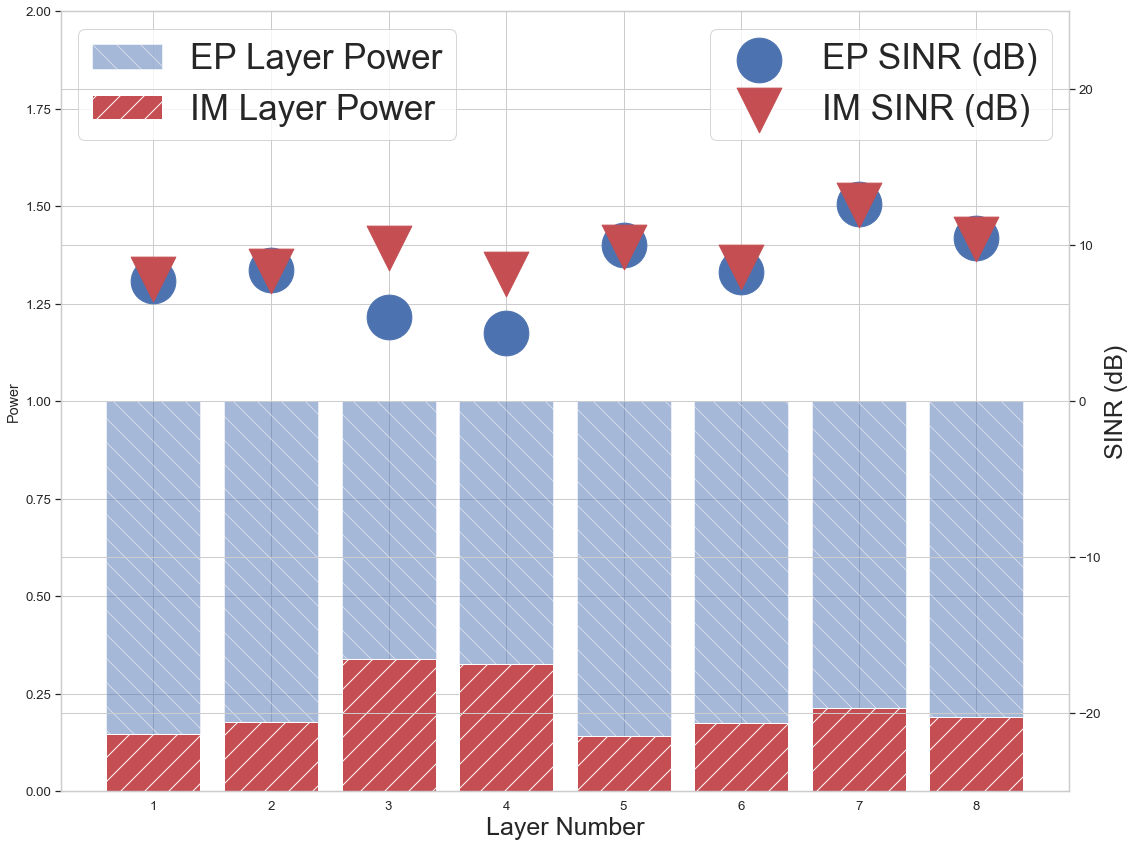

In [34]:
fig, ax = plt.subplots(figsize=(16,12))
ax1 = ax.twinx()

ax.bar(np.arange(W_IM.shape[1]) + 1, W_ZF.norm(dim=0) / W_ZF.norm(dim=0), alpha=0.5, color="b", label="EP Layer Power", hatch="\\")
ax.bar(np.arange(W_IM.shape[1]) + 1, W_IM.norm(dim=0) / W_ZF.norm(dim=0), alpha=1, color='r' , label="IM Layer Power", hatch="/")


ax1.scatter(np.arange(W_IM.shape[1]) + 1, sinr_zf, s=2000, color="b", label="EP SINR (dB)")
ax1.scatter(np.arange(W_IM.shape[1]) + 1, sinr_im, s=2000, marker='v', color="r", label="IM SINR (dB)")

ax.set_ylabel('Power')
ax1.set_ylabel('SINR (dB)', fontsize = 25)

ax.set_ylim((0,2))
ax1.set_ylim((-25,25))

ax.set_xlabel("Layer Number", fontsize = 25)
ax.legend(loc="upper left", fontsize = 35)
ax1.legend(loc="upper right", fontsize = 35)
plt.tight_layout()
plt.savefig("Images/PowerAllocationExample2.pdf", bbox_inches="tight")

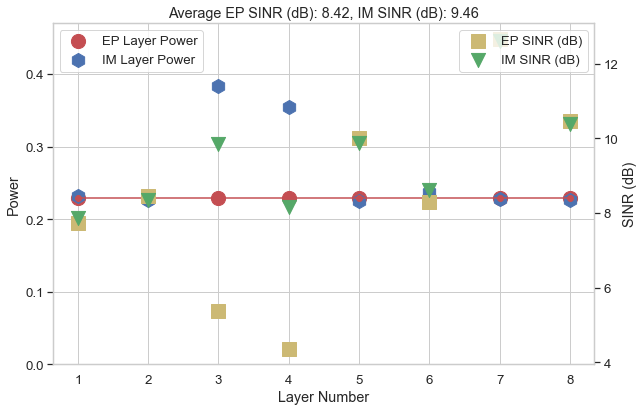

In [69]:
def two_scales(ax1, time, data1, data11, data2, data21, c1, c2):
    ax2 = ax1.twinx()
    ax1.scatter(time, data1, marker="o", s=200,  c="r", label="EP Layer Power")
    ax1.plot(time, data1, marker="o", c="r")
    ax1.scatter(time, data11, marker="h", s=200, c="b", label="IM Layer Power")
    ax1.set_xlabel('Layer Number')
    ax1.set_ylabel('Power')
    ax1.set_ylim(0, 0.47)
    ax2.scatter(time, data2, marker="s", s=200, c="y", label="EP SINR (dB)")
    ax2.scatter(time, data21, marker="v", s=200, c="g", label="IM SINR (dB)")
    ax2.set_ylabel('SINR (dB)')
    return ax1, ax2

# Create axes
fig, ax = plt.subplots()
#plt.yscale("log")
#ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')
ax1, ax2 = two_scales(ax, np.arange(W_IM.shape[1]) + 1, W_RZF.norm(dim=0), W_IM.norm(dim=0), sinr_zf, sinr_im, 'r', 'b')

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

# color_y_axis(ax1, 'r')
# color_y_axis(ax2, 'b')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title(f"Average EP SINR (dB): {np.round(sinr_zf.mean(), 2)}, IM SINR (dB): {np.round(sinr_im.mean(), 2)}")
plt.grid()
#plt.tight_layout()
plt.savefig("Images/PowerAllocationExample.pdf", bbox_inches="tight")

# Massive Experiments

In [58]:
history = defaultdict(list)
n_ranks = 2
#full_path = "save_data/n_users=8/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/*"
full_path = "../save_data/n_users=8/3GPP_38.901_UMa_NLOS/**/*.mat"

for i, path in enumerate(glob(full_path, recursive=True)):
    H = loadmat(path)["coeff"][..., -1]
    S, V = np.linalg.svd(H, full_matrices=False)[1:]
    history["Correlation"].append(calc_corr(V[:, 0, :]))
round(mean(history["Correlation"]), 3), round(stdev(history["Correlation"]), 3)

(0.078, 0.036)

In [59]:
full_path = "../save_data/n_users=4/3GPP_38.901_UMa_NLOS/**/*.mat"
len(glob(full_path, recursive=True))

40

In [60]:
list(next(enumerate(glob(full_path, recursive=True))))

[0,
 '../save_data/n_users=4/3GPP_38.901_UMa_NLOS\\close_users\\urban\\correlated_users\\coeff.1.mat']

In [61]:
# def calc_corr(A, B):
#     return (np.abs(np.corrcoef(A.conj().T, B)) ** 2).mean()

history_rzf, times = defaultdict(list), defaultdict(list)
s_grid = np.logspace(1, -10, num=2000)
n_antennas, n_ranks = 64, 2
n_iters, mantissa = 2, 4
#full_path = "save_data/n_users=4/3GPP_38.901_UMa_NLOS/far_users/urban/notcorrelated_users/*"
full_path = "../save_data/n_users=4/3GPP_38.901_UMa_NLOS/**/*.mat"
#full_path = "../save_data/n_users=4/3GPP_38.901_UMa_NLOS/close_users/urban/correlated_users/coeff.1.mat"
s_list = []

for target_sinr in tqdm(range(7, 43, 3)):
    for i, path in enumerate(glob(full_path, recursive=True)):
        H = loadmat(path)["coeff"][..., -1]
#         H[0] *= 5
#         H[1] *= 2
#         H[2] /= 2
#         H[3] /= 5
#         H[4] /= 2
#         H[5] /= 5
#         H[6] /= 7
#         H[7] /= 10

        H[0] *= 5
        H[1] *= 2
        H[2] /= 2
        H[3] /= 5
        
        n_users, n_layers, n_antennas = H.shape # Global constants
        S, V = np.linalg.svd(H, full_matrices=False)[1:]
        S_max = S[:, 0].max()
        H /= S_max; S /= S_max
        
#        history_rzf["Correlation"].append(calc_corr(V[:, 0, :]))
        
        V = torch.from_numpy(V[:, :n_ranks, :].reshape(-1, n_antennas))
        S = torch.from_numpy(S[:, :n_ranks].flatten())
        H = torch.from_numpy(H)

        flying_sinr = FlyingSuSinr(S, s_grid)
        s = s_grid[bisect(flying_sinr, target_sinr)]
        
        s_list.append(s)

        R = (s / S) ** 2
        #R = 1
        alpha = db2lin(-su_sinr(S, s))
        scale = n_users * n_ranks

        Q = ((1 / S) ** 2).reshape(n_users, n_ranks)
        
#         'Regularized Zero-Forcing',
#        'Single Step Optimization', 'Double Step Optimization',
#        'Quazi-Newton Converged'
        
#         start = time()
#         W_MR = normalize_precoding(V.conj().t())
#         times["MRT"].append(time() - start)
#         history_rzf["MRT"].append(float(spectral_efficiency_irc(H, W_MR, s)))
        
        W_RZF = normalize_max_antennas(regularized(V, s ** 2))
        print("RZF")
        print("Primal", W_RZF.norm(dim=0))
        print("Inv", 1 / W_RZF.norm(dim=0) / (1 / W_RZF.norm(dim=0)).max())
        history_rzf["BP"].append(float(spectral_efficiency_irc(H, W_RZF, s)))
    
#         A = (W_RZF * W_RZF.conj()).real
#         P = (1 / W_RZF.norm(dim=0))
#         P = intersection_power_method(A, P)
#         W_IM = normalize_max_antennas(W_RZF * P)
#         history_rzf["IM RAW"].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        #W_RZF = normalize_max_antennas(regularized(V, s ** 2))
        print("Table 1")
        history_rzf["BP Table 1"].append(float(spectral_efficiency_irc_qam(H, W_RZF, s, 0)))
        
        #W_RZF = normalize_max_antennas(regularized(V, s ** 2))
        print("Table 2")
        history_rzf["BP Table 2"].append(float(spectral_efficiency_irc_qam(H, W_RZF, s, 1)))
        
#         A = (W_RZF * W_RZF.conj()).real
#         P = (1 / W_RZF.norm(dim=0))
#         P = intersection_power_method(A, P)
#         W_IM = normalize_max_antennas(W_RZF * P)
#         history_rzf["IM RAW MCS"].append(float(ideal_efficiene(V, W_IM, R)))
        
        W_RZF = normalize_precoding(regularized(V, s ** 2))
        print("EP")
        history_rzf["EP"].append(float(spectral_efficiency_irc(H, W_RZF, s)))
        
        W_RZF = normalize_precoding(regularized(V, s ** 2))
        print("EP Table 1")
        history_rzf["EP Table 1"].append(float(spectral_efficiency_irc_qam(H, W_RZF, s, 0)))
        
        W_RZF = normalize_precoding(regularized(V, s ** 2))
        print("EP Table 2")
        history_rzf["EP Table 2"].append(float(spectral_efficiency_irc_qam(H, W_RZF, s, 1)))
        
#         POWER ALLOCATION METHODS
                    

        
        w_norm = regularized(V, s ** 2).norm(dim=0)
        W_WF = normalize_precoding(regularized(V, s ** 2))
        P = 1 / (n_users * n_ranks) - (s / S ) ** 2 # * w_norm/ 8 #
        P = P + (1 - P.sum())/(n_users * n_ranks)
        P[P < 0] = np.finfo(np.float64).eps
        P /= P.sum()
        P = P.sqrt()
        W_WF = normalize_max_antennas(W_WF * P)
        
        history_rzf["WF"].append(float(spectral_efficiency_irc(H, W_WF, s)))
#         history_rzf["WF Table 1"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 0)))
#         history_rzf["WF Table 2"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 1)))
        
#         W_WF = normalize_precoding(regularized(V, s ** 2))
#         P = 1 / (n_users * n_ranks) - (s / S) ** 2
#         P = P.sqrt()
#         if (P > 0).all():
#             W_WF = normalize_max_antennas(W_WF * P)
        
#         history_rzf["WF Morning"].append(float(spectral_efficiency_irc(H, W_WF, s)))
#         history_rzf["WF Morning Table 1"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 0)))
#         history_rzf["WF Morning Table 2"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 1)))
        
        
        # WF + INTERSECTION

        W_RZF = regularized(V, s ** 2)
        w_norm = W_RZF.norm(dim=0)
        W_WF = normalize_precoding(W_RZF)
        P = 1 / (n_users * n_ranks) - (s / S) ** 2 #*w_norm
        P = P + (1 - P.sum())/(n_users * n_ranks)
        P[P < 0] = np.finfo(np.float64).eps
        P /= P.sum()
        P = P.sqrt()
        A = (W_WF * W_WF.conj()).real
        P = intersection_power_method(A, P)
        W_WF = normalize_max_antennas(W_WF * P)

        history_rzf["WF IM"].append(float(spectral_efficiency_irc(H, W_WF, s)))
#         history_rzf["WF IM Table 1"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 0)))
#         history_rzf["WF IM Table 2"].append(float(spectral_efficiency_irc_qam(H, W_WF, s, 1)))
        
#         W_RZF = normalize_precoding(regularized(V, s ** 2))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_RZF * P) 
#         history_rzf["ZN"].append(float(spectral_efficiency_irc(H, W_ZN, s)))
        
#         W_RZF = normalize_precoding(regularized(V, s ** 2))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_RZF * P) 
#         history_rzf["ZN Table 1"].append(float(spectral_efficiency_irc_qam(H, W_ZN, s, 0)))
        
#         W_RZF = normalize_precoding(regularized(V, s ** 2))
#         P = (Q / Q.sum(dim=1, keepdim=True)).flatten() ** 0.5
#         W_ZN = normalize_max_antennas(W_RZF * P) 
#         history_rzf["ZN Table 2"].append(float(spectral_efficiency_irc_qam(H, W_ZN, s, 1)))
        
        W_RZF = regularized(V, s ** 2) 
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM")
        print(P / P.max())
        history_rzf["IM"].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        W_RZF = regularized(V, s ** 2)
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM Table 1")
        print(P / P.max())
        history_rzf["IM Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        W_RZF = regularized(V, s ** 2)
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method(A, P)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM Table 2")
        print(P / P.max())
        history_rzf["IM Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))
        
#         A = (W_RZF * W_RZF.conj()).real
#         P = (1 / W_RZF.norm(dim=0))
#         P = intersection_power_method_new(A, P, R)
#         W_IM = normalize_max_antennas(W_RZF * P)
#         history_rzf["IM MCS "].append(float(spectral_efficiency_irc(H, W_IM, s)))
        
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method_new(A, P, R, H, W_RZF, s, 0)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM MCS CD Table 1")
        print(P / P.max())
        history_rzf["IM MCS CD Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method_new(A, P, R, H, W_RZF, s, 1)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM MCS CD Table 2")
        print(P / P.max())
        history_rzf["IM MCS CD Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))
        
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method_new_irc(A, P, H, W_RZF, s, 0)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM MCS IRC Table 1")
        print(P / P.max())
        history_rzf["IM MCS IRC Table 1"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 0)))
        
        A = (W_RZF * W_RZF.conj()).real
        P = (1 / W_RZF.norm(dim=0))
        P = intersection_power_method_new_irc(A, P, H, W_RZF, s, 1)
        W_IM = normalize_max_antennas(W_RZF * P)
        print("IM MCS IRC Table 2")
        print(P / P.max())
        history_rzf["IM MCS IRC Table 2"].append(float(spectral_efficiency_irc_qam(H, W_IM, s, 1)))

        history_rzf["SU SINR"].append(target_sinr)
        times["SU SINR"].append(target_sinr)

  0%|          | 0/12 [00:00<?, ?it/s]

RZF
Primal tensor([0.3082, 0.2545, 0.2539, 0.2727, 0.1900, 0.1971, 0.2259, 0.2042],
       dtype=torch.float64)
Inv tensor([0.6164, 0.7466, 0.7483, 0.6967, 1.0000, 0.9640, 0.8411, 0.9306],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.5300, 0.6415, 1.0000, 0.5990, 0.8593, 0.8605, 0.7227, 0.8006],
       dtype=torch.float64)
IM Table 1
tensor([0.5300, 0.6415, 1.0000, 0.5990, 0.8593, 0.8605, 0.7227, 0.8006],
       dtype=torch.float64)
IM Table 2
tensor([0.5300, 0.6415, 1.0000, 0.5990, 0.8593, 0.8605, 0.7227, 0.8006],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.6164, 0.7466, 0.7483, 0.6967, 1.0000, 0.9640, 0.8411, 0.9306],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6164, 0.7466, 0.7483, 0.6967, 1.0000, 0.9640, 0.8411, 0.9306],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.4856, 0.6039, 0.7445, 0.6298, 0.8305, 1.0000, 0.4778, 0.7840],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.4896, 0.6187,

Primal tensor([0.2949, 0.2342, 0.2170, 0.2497, 0.2945, 0.2406, 0.2403, 0.2369],
       dtype=torch.float64)
Inv tensor([0.7360, 0.9268, 1.0000, 0.8693, 0.7370, 0.9022, 0.9034, 0.9161],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.7083, 0.9010, 0.9592, 0.7865, 0.6726, 0.8660, 0.9771, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.7083, 0.9010, 0.9592, 0.7865, 0.6726, 0.8660, 0.9771, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.7083, 0.9010, 0.9592, 0.7865, 0.6726, 0.8660, 0.9771, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7011, 0.9026, 0.9172, 0.8262, 0.5501, 0.7776, 0.9360, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6967, 0.8924, 0.9197, 0.8213, 0.5728, 0.7867, 0.9472, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7139, 0.9127, 0.9289, 0.8376, 0.5318, 0.8168, 0.9765, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7058, 0.8990, 0.9284, 0.8291, 0

Primal tensor([0.2345, 0.2256, 0.2558, 0.2345, 0.2361, 0.2143, 0.2257, 0.2415],
       dtype=torch.float64)
Inv tensor([0.9136, 0.9498, 0.8378, 0.9138, 0.9077, 1.0000, 0.9494, 0.8874],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6329, 0.6639, 0.5836, 0.6330, 1.0000, 0.6936, 0.6598, 0.6155],
       dtype=torch.float64)
IM Table 1
tensor([0.6329, 0.6639, 0.5836, 0.6330, 1.0000, 0.6936, 0.6598, 0.6155],
       dtype=torch.float64)
IM Table 2
tensor([0.6329, 0.6639, 0.5836, 0.6330, 1.0000, 0.6936, 0.6598, 0.6155],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7076, 0.8372, 0.6288, 0.7300, 1.0000, 0.5563, 0.7306, 0.4362],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7076, 0.8375, 0.6281, 0.7292, 1.0000, 0.5568, 0.7306, 0.4366],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6687, 0.7381, 0.6054, 0.6776, 1.0000, 0.6836, 0.6573, 0.5281],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6686, 0.7382, 0.6042, 0.6770, 1

tensor([0.5445, 0.6196, 0.5515, 0.6995, 0.6747, 0.8601, 1.0000, 0.9447],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.5445, 0.6198, 0.5514, 0.6996, 0.6746, 0.8590, 1.0000, 0.9437],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.5478, 0.6231, 0.5551, 0.7022, 0.6765, 0.8728, 1.0000, 0.9674],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.5512, 0.6273, 0.5584, 0.7075, 0.6821, 0.8714, 1.0000, 0.9693],
       dtype=torch.float64)
RZF
Primal tensor([0.2181, 0.1744, 0.3159, 0.1928, 0.3008, 0.2112, 0.2032, 0.2055],
       dtype=torch.float64)
Inv tensor([0.7996, 1.0000, 0.5520, 0.9043, 0.5797, 0.8258, 0.8583, 0.8486],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.7161, 1.0000, 0.4650, 0.7703, 0.5004, 0.6951, 0.7425, 0.7773],
       dtype=torch.float64)
IM Table 1
tensor([0.7161, 1.0000, 0.4650, 0.7703, 0.5004, 0.6951, 0.7425, 0.7773],
       dtype=torch.float64)
IM Table 2
tensor([0.7161, 1.0000, 0.4650, 0.7703, 0.5004, 0.6951,

IM
tensor([0.5579, 0.5023, 0.5619, 1.0000, 0.8277, 0.5879, 0.7764, 0.6237],
       dtype=torch.float64)
IM Table 1
tensor([0.5579, 0.5023, 0.5619, 1.0000, 0.8277, 0.5879, 0.7764, 0.6237],
       dtype=torch.float64)
IM Table 2
tensor([0.5579, 0.5023, 0.5619, 1.0000, 0.8277, 0.5879, 0.7764, 0.6237],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.6598, 0.8312, 0.6923, 0.8464, 0.8265, 1.0000, 0.7149, 0.7389],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6598, 0.8312, 0.6923, 0.8464, 0.8265, 1.0000, 0.7149, 0.7389],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6598, 0.8312, 0.6923, 0.8464, 0.8265, 1.0000, 0.7149, 0.7389],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6598, 0.8312, 0.6923, 0.8464, 0.8265, 1.0000, 0.7149, 0.7389],
       dtype=torch.float64)
RZF
Primal tensor([0.2728, 0.2758, 0.2665, 0.2684, 0.2619, 0.2785, 0.2760, 0.2711],
       dtype=torch.float64)
Inv tensor([0.9600, 0.9498, 0.9828, 0.9757, 1.0000, 0.

tensor([0.6835, 0.4050, 0.8573, 1.0000, 0.5678, 0.6761, 0.4931, 0.6655],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7045, 0.4317, 0.8958, 1.0000, 0.5956, 0.7123, 0.4869, 0.6169],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7043, 0.4317, 0.8956, 1.0000, 0.5935, 0.7091, 0.4875, 0.6201],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7001, 0.4296, 0.8981, 1.0000, 0.5797, 0.6882, 0.4723, 0.6402],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7025, 0.4311, 0.8995, 1.0000, 0.5897, 0.6999, 0.4699, 0.6290],
       dtype=torch.float64)
RZF
Primal tensor([0.2105, 0.2640, 0.2467, 0.2314, 0.2268, 0.2256, 0.2418, 0.2292],
       dtype=torch.float64)
Inv tensor([1.0000, 0.7974, 0.8533, 0.9095, 0.9282, 0.9329, 0.8706, 0.9185],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.7218, 0.5618, 0.7590, 0.6555, 0.6527, 0.6541, 1.0000, 0.6468],
       dtype=torch.float64)
IM Table 1
tensor([0.7218, 0.5618, 0.7590, 0.6555, 0.6527, 

tensor([0.4612, 1.0000, 0.4905, 0.6285, 0.4744, 0.5882, 0.5431, 0.6300],
       dtype=torch.float64)
IM Table 1
tensor([0.4612, 1.0000, 0.4905, 0.6285, 0.4744, 0.5882, 0.5431, 0.6300],
       dtype=torch.float64)
IM Table 2
tensor([0.4612, 1.0000, 0.4905, 0.6285, 0.4744, 0.5882, 0.5431, 0.6300],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.6880, 1.0000, 0.5165, 0.9357, 0.6750, 0.6864, 0.5608, 0.8341],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6880, 1.0000, 0.5165, 0.9357, 0.6750, 0.6864, 0.5608, 0.8341],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6880, 1.0000, 0.5165, 0.9357, 0.6750, 0.6864, 0.5608, 0.8341],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6880, 1.0000, 0.5165, 0.9357, 0.6750, 0.6864, 0.5608, 0.8341],
       dtype=torch.float64)
RZF
Primal tensor([0.1867, 0.1950, 0.2330, 0.1983, 0.1948, 0.2832, 0.2526, 0.1856],
       dtype=torch.float64)
Inv tensor([0.9938, 0.9515, 0.7964, 0.9357, 0.9528, 0.655

Primal tensor([0.2069, 0.2078, 0.2303, 0.2372, 0.2581, 0.2744, 0.2215, 0.2786],
       dtype=torch.float64)
Inv tensor([1.0000, 0.9959, 0.8986, 0.8722, 0.8017, 0.7541, 0.9340, 0.7426],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.9167, 1.0000, 0.8067, 0.7679, 0.7063, 0.6933, 0.8262, 0.6743],
       dtype=torch.float64)
IM Table 1
tensor([0.9167, 1.0000, 0.8067, 0.7679, 0.7063, 0.6933, 0.8262, 0.6743],
       dtype=torch.float64)
IM Table 2
tensor([0.9167, 1.0000, 0.8067, 0.7679, 0.7063, 0.6933, 0.8262, 0.6743],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.9760, 1.0000, 0.8163, 0.8030, 0.7360, 0.7119, 0.8398, 0.4500],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.9760, 1.0000, 0.8161, 0.8026, 0.7356, 0.7108, 0.8400, 0.4525],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.9621, 1.0000, 0.7720, 0.7661, 0.7009, 0.6994, 0.6807, 0.5620],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.9627, 1.0000, 0.7723, 0.7661, 0

Primal tensor([0.2054, 0.1938, 0.1748, 0.1325, 0.1626, 0.2230, 0.1599, 0.2672],
       dtype=torch.float64)
Inv tensor([0.6450, 0.6838, 0.7579, 1.0000, 0.8147, 0.5940, 0.8286, 0.4959],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4653, 0.5101, 0.5495, 1.0000, 0.6002, 0.4301, 0.5978, 0.3585],
       dtype=torch.float64)
IM Table 1
tensor([0.4653, 0.5101, 0.5495, 1.0000, 0.6002, 0.4301, 0.5978, 0.3585],
       dtype=torch.float64)
IM Table 2
tensor([0.4653, 0.5101, 0.5495, 1.0000, 0.6002, 0.4301, 0.5978, 0.3585],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.6450, 0.6838, 0.7579, 1.0000, 0.8147, 0.5940, 0.8286, 0.4959],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6450, 0.6838, 0.7579, 1.0000, 0.8147, 0.5940, 0.8286, 0.4959],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6450, 0.6838, 0.7579, 1.0000, 0.8147, 0.5940, 0.8286, 0.4959],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.645

tensor([0.8477, 0.9902, 1.0000, 0.9652, 0.6720, 0.6612, 0.5961, 0.4882],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.8488, 0.9930, 1.0000, 0.9648, 0.6717, 0.6586, 0.5967, 0.4897],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.8469, 0.9901, 1.0000, 0.9650, 0.6721, 0.6607, 0.5923, 0.4871],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.8487, 0.9941, 1.0000, 0.9645, 0.6718, 0.6575, 0.5934, 0.4896],
       dtype=torch.float64)
RZF
Primal tensor([0.1035, 0.1095, 0.1815, 0.2454, 0.2409, 0.1614, 0.1653, 0.1211],
       dtype=torch.float64)
Inv tensor([1.0000, 0.9460, 0.5706, 0.4219, 0.4298, 0.6418, 0.6266, 0.8549],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([1.0000, 0.9235, 0.5534, 0.4082, 0.4179, 0.6225, 0.9133, 0.8473],
       dtype=torch.float64)
IM Table 1
tensor([1.0000, 0.9235, 0.5534, 0.4082, 0.4179, 0.6225, 0.9133, 0.8473],
       dtype=torch.float64)
IM Table 2
tensor([1.0000, 0.9235, 0.5534, 0.4082, 0.4179, 0.6225,

Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6131, 0.5300, 0.9064, 0.8951, 0.6646, 0.5298, 0.7430, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.6131, 0.5300, 0.9064, 0.8951, 0.6646, 0.5298, 0.7430, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.6131, 0.5300, 0.9064, 0.8951, 0.6646, 0.5298, 0.7430, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6056, 0.5541, 0.7254, 1.0000, 0.6018, 0.4775, 0.5540, 0.0928],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.8174, 0.6756, 0.9321, 1.0000, 0.7687, 0.7390, 0.9993, 0.9631],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6556, 0.5813, 0.7758, 1.0000, 0.6414, 0.5180, 0.6701, 0.7581],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6589, 0.5848, 0.7755, 1.0000, 0.6441, 0.5296, 0.6490, 0.7558],
       dtype=torch.float64)
RZF
Primal tensor([0.3080, 0.2249, 0.1995, 0.2379, 0.3076, 0.2322, 0.2278, 0.2229],
       dtype=torch.float64)
Inv tensor([0.6476, 0.8870, 1.0000, 0.8387

IM MCS IRC Table 2
tensor([0.9355, 1.0000, 0.4258, 0.8196, 0.5356, 0.7741, 0.6531, 0.6717],
       dtype=torch.float64)
RZF
Primal tensor([0.3014, 0.1923, 0.2991, 0.1924, 0.1960, 0.1896, 0.1526, 0.1607],
       dtype=torch.float64)
Inv tensor([0.5063, 0.7934, 0.5102, 0.7932, 0.7787, 0.8049, 1.0000, 0.9494],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.3064, 0.4822, 0.3091, 0.4795, 0.4760, 0.4895, 1.0000, 0.5759],
       dtype=torch.float64)
IM Table 1
tensor([0.3064, 0.4822, 0.3091, 0.4795, 0.4760, 0.4895, 1.0000, 0.5759],
       dtype=torch.float64)
IM Table 2
tensor([0.3064, 0.4822, 0.3091, 0.4795, 0.4760, 0.4895, 1.0000, 0.5759],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.3263, 0.5503, 0.3358, 0.5177, 0.5291, 0.3412, 1.0000, 0.3740],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.3236, 0.5433, 0.3297, 0.5117, 0.5282, 0.3595, 1.0000, 0.3787],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.3245, 0.5437, 0.3332, 0.512

IM MCS IRC Table 2
tensor([0.4055, 0.4963, 0.8890, 1.0000, 0.4018, 0.4828, 0.5731, 0.4793],
       dtype=torch.float64)
RZF
Primal tensor([0.2791, 0.2276, 0.2281, 0.2260, 0.2778, 0.2204, 0.2654, 0.2162],
       dtype=torch.float64)
Inv tensor([0.7747, 0.9502, 0.9478, 0.9569, 0.7784, 0.9812, 0.8147, 1.0000],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.8581, 0.8174, 0.9891, 0.8090, 0.6601, 0.8313, 0.7761, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.8581, 0.8174, 0.9891, 0.8090, 0.6601, 0.8313, 0.7761, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.8581, 0.8174, 0.9891, 0.8090, 0.6601, 0.8313, 0.7761, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6368, 0.7955, 0.7493, 0.7738, 0.6018, 0.7010, 0.7641, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6360, 0.7943, 0.7484, 0.7723, 0.6020, 0.7015, 0.7640, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6523, 0.8138, 0.7699, 0.793

IM MCS CD Table 1
tensor([0.6613, 0.9498, 0.9972, 0.8346, 0.7177, 1.0000, 0.9177, 0.8381],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6613, 0.9498, 0.9972, 0.8346, 0.7177, 1.0000, 0.9177, 0.8381],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6613, 0.9498, 0.9972, 0.8346, 0.7177, 1.0000, 0.9177, 0.8381],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6613, 0.9498, 0.9972, 0.8346, 0.7177, 1.0000, 0.9177, 0.8381],
       dtype=torch.float64)
RZF
Primal tensor([0.2173, 0.2148, 0.2581, 0.2188, 0.2607, 0.2511, 0.2575, 0.2399],
       dtype=torch.float64)
Inv tensor([0.9883, 1.0000, 0.8322, 0.9816, 0.8237, 0.8552, 0.8339, 0.8951],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6655, 0.6771, 0.5605, 1.0000, 0.5550, 0.5957, 0.5615, 0.6233],
       dtype=torch.float64)
IM Table 1
tensor([0.6655, 0.6771, 0.5605, 1.0000, 0.5550, 0.5957, 0.5615, 0.6233],
       dtype=torch.float64)
IM Table 2
tensor([0.6655, 

tensor([0.9364, 1.0000, 0.6513, 0.6972, 0.5435, 0.4279, 0.7447, 0.3763],
       dtype=torch.float64)
RZF
Primal tensor([0.2489, 0.1976, 0.2098, 0.2536, 0.1744, 0.1968, 0.2114, 0.2375],
       dtype=torch.float64)
Inv tensor([0.7007, 0.8829, 0.8317, 0.6878, 1.0000, 0.8863, 0.8253, 0.7345],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.7406, 0.9773, 0.8254, 0.6806, 1.0000, 0.9951, 0.8473, 0.7242],
       dtype=torch.float64)
IM Table 1
tensor([0.7406, 0.9773, 0.8254, 0.6806, 1.0000, 0.9951, 0.8473, 0.7242],
       dtype=torch.float64)
IM Table 2
tensor([0.7406, 0.9773, 0.8254, 0.6806, 1.0000, 0.9951, 0.8473, 0.7242],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7202, 0.9407, 0.8167, 0.6832, 1.0000, 0.9557, 0.8117, 0.6522],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7200, 0.9404, 0.8165, 0.6829, 1.0000, 0.9558, 0.8121, 0.6521],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7190, 0.9396, 0.8148, 0.6818, 1.0000, 0.9529, 

IM MCS IRC Table 1
tensor([0.6974, 0.6339, 0.5658, 0.6594, 0.7353, 0.7737, 1.0000, 0.9486],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6771, 0.6140, 0.5553, 0.6511, 0.7013, 0.6563, 1.0000, 0.9030],
       dtype=torch.float64)
RZF
Primal tensor([0.3186, 0.2497, 0.2544, 0.2772, 0.1794, 0.1865, 0.2181, 0.1944],
       dtype=torch.float64)
Inv tensor([0.5629, 0.7182, 0.7051, 0.6471, 1.0000, 0.9618, 0.8223, 0.9226],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4945, 0.6298, 1.0000, 0.5682, 0.8772, 0.9268, 0.7212, 0.8112],
       dtype=torch.float64)
IM Table 1
tensor([0.4945, 0.6298, 1.0000, 0.5682, 0.8772, 0.9268, 0.7212, 0.8112],
       dtype=torch.float64)
IM Table 2
tensor([0.4945, 0.6298, 1.0000, 0.5682, 0.8772, 0.9268, 0.7212, 0.8112],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.5629, 0.7182, 0.7051, 0.6471, 1.0000, 0.9618, 0.8223, 0.9226],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.5629, 0.7182,

tensor([0.6370, 0.8835, 1.0000, 0.7971, 0.6146, 0.8743, 0.9925, 0.9863],
       dtype=torch.float64)
IM Table 1
tensor([0.6370, 0.8835, 1.0000, 0.7971, 0.6146, 0.8743, 0.9925, 0.9863],
       dtype=torch.float64)
IM Table 2
tensor([0.6370, 0.8835, 1.0000, 0.7971, 0.6146, 0.8743, 0.9925, 0.9863],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6305, 0.8828, 0.9504, 0.8262, 0.4760, 0.7888, 0.9329, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6303, 0.8820, 0.9523, 0.8256, 0.4775, 0.7920, 0.9340, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6312, 0.8837, 0.9513, 0.8270, 0.4761, 0.7904, 0.9354, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6310, 0.8828, 0.9533, 0.8265, 0.4776, 0.7936, 0.9366, 1.0000],
       dtype=torch.float64)
RZF
Primal tensor([0.2361, 0.2483, 0.2167, 0.1875, 0.1946, 0.1851, 0.2144, 0.2685],
       dtype=torch.float64)
Inv tensor([0.7838, 0.7454, 0.8541, 0.9872, 0.9509, 1.0000, 0.8631, 0.6894],
       d

IM MCS IRC Table 2
tensor([0.3172, 0.5405, 0.3272, 0.5091, 0.5208, 0.3322, 1.0000, 0.3748],
       dtype=torch.float64)
RZF
Primal tensor([0.2147, 0.1565, 0.1896, 0.2031, 0.1720, 0.1958, 0.2314, 0.2000],
       dtype=torch.float64)
Inv tensor([0.7286, 1.0000, 0.8253, 0.7706, 0.9095, 0.7990, 0.6762, 0.7824],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6775, 1.0000, 0.8383, 0.7165, 0.8931, 0.7491, 0.6264, 0.7347],
       dtype=torch.float64)
IM Table 1
tensor([0.6775, 1.0000, 0.8383, 0.7165, 0.8931, 0.7491, 0.6264, 0.7347],
       dtype=torch.float64)
IM Table 2
tensor([0.6775, 1.0000, 0.8383, 0.7165, 0.8931, 0.7491, 0.6264, 0.7347],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.7286, 1.0000, 0.8253, 0.7706, 0.9095, 0.7990, 0.6762, 0.7824],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.7286, 1.0000, 0.8253, 0.7706, 0.9095, 0.7990, 0.6762, 0.7824],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7389, 1.0000,

EP Table 2
IM
tensor([0.8580, 0.8169, 0.9884, 0.8085, 0.6590, 0.8309, 0.7753, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.8580, 0.8169, 0.9884, 0.8085, 0.6590, 0.8309, 0.7753, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.8580, 0.8169, 0.9884, 0.8085, 0.6590, 0.8309, 0.7753, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6352, 0.7943, 0.7481, 0.7735, 0.5997, 0.6990, 0.7630, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6350, 0.7937, 0.7476, 0.7719, 0.6005, 0.7002, 0.7631, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6376, 0.7968, 0.7521, 0.7769, 0.6008, 0.7074, 0.7728, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6374, 0.7962, 0.7516, 0.7753, 0.6017, 0.7085, 0.7728, 1.0000],
       dtype=torch.float64)
RZF
Primal tensor([0.2609, 0.3303, 0.2341, 0.2524, 0.2332, 0.2513, 0.3023, 0.2448],
       dtype=torch.float64)
Inv tensor([0.8936, 0.7059, 0.9961, 0.9238, 1.0000, 0.9278, 0.7713, 0.9

IM MCS IRC Table 1
tensor([0.6571, 0.9503, 0.9976, 0.8322, 0.7146, 1.0000, 0.9172, 0.8357],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6571, 0.9503, 0.9976, 0.8322, 0.7146, 1.0000, 0.9172, 0.8357],
       dtype=torch.float64)
RZF
Primal tensor([0.2172, 0.2146, 0.2580, 0.2187, 0.2607, 0.2511, 0.2575, 0.2398],
       dtype=torch.float64)
Inv tensor([0.9882, 1.0000, 0.8318, 0.9816, 0.8233, 0.8549, 0.8335, 0.8950],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6654, 0.6770, 0.5602, 1.0000, 0.5547, 0.5954, 0.5612, 0.6231],
       dtype=torch.float64)
IM Table 1
tensor([0.6654, 0.6770, 0.5602, 1.0000, 0.5547, 0.5954, 0.5612, 0.6231],
       dtype=torch.float64)
IM Table 2
tensor([0.6654, 0.6770, 0.5602, 1.0000, 0.5547, 0.5954, 0.5612, 0.6231],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7926, 0.8253, 0.6763, 1.0000, 0.6739, 0.7338, 0.6005, 0.7716],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.8000, 0.8315, 0.6822

tensor([0.7179, 0.9390, 0.8160, 0.6809, 1.0000, 0.9546, 0.8107, 0.6519],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7175, 0.9382, 0.8159, 0.6807, 1.0000, 0.9546, 0.8111, 0.6510],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7176, 0.9388, 0.8155, 0.6805, 1.0000, 0.9538, 0.8097, 0.6511],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7172, 0.9379, 0.8153, 0.6803, 1.0000, 0.9538, 0.8101, 0.6501],
       dtype=torch.float64)
RZF
Primal tensor([0.1734, 0.1364, 0.2465, 0.1499, 0.2193, 0.1217, 0.1395, 0.0890],
       dtype=torch.float64)
Inv tensor([0.5135, 0.6526, 0.3613, 0.5942, 0.4060, 0.7315, 0.6384, 1.0000],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4247, 0.4724, 0.2549, 0.4257, 0.2847, 0.5179, 1.0000, 0.9832],
       dtype=torch.float64)
IM Table 1
tensor([0.4247, 0.4724, 0.2549, 0.4257, 0.2847, 0.5179, 1.0000, 0.9832],
       dtype=torch.float64)
IM Table 2
tensor([0.4247, 0.4724, 0.2549, 0.4257, 0.2847, 0.5179,

RZF
Primal tensor([0.3189, 0.2496, 0.2544, 0.2773, 0.1791, 0.1862, 0.2179, 0.1942],
       dtype=torch.float64)
Inv tensor([0.5615, 0.7175, 0.7039, 0.6458, 1.0000, 0.9617, 0.8218, 0.9224],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4940, 0.6300, 1.0000, 0.5679, 0.8783, 0.9348, 0.7218, 0.8123],
       dtype=torch.float64)
IM Table 1
tensor([0.4940, 0.6300, 1.0000, 0.5679, 0.8783, 0.9348, 0.7218, 0.8123],
       dtype=torch.float64)
IM Table 2
tensor([0.4940, 0.6300, 1.0000, 0.5679, 0.8783, 0.9348, 0.7218, 0.8123],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.5615, 0.7175, 0.7039, 0.6458, 1.0000, 0.9617, 0.8218, 0.9224],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.5615, 0.7175, 0.7039, 0.6458, 1.0000, 0.9617, 0.8218, 0.9224],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.5615, 0.7175, 0.7039, 0.6458, 1.0000, 0.9617, 0.8218, 0.9224],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0

Primal tensor([0.2269, 0.2765, 0.1978, 0.1835, 0.2421, 0.2521, 0.1839, 0.1907],
       dtype=torch.float64)
Inv tensor([0.8090, 0.6638, 0.9278, 1.0000, 0.7581, 0.7279, 0.9979, 0.9622],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6098, 0.5226, 0.8971, 0.9000, 0.6562, 0.5255, 0.7462, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.6098, 0.5226, 0.8971, 0.9000, 0.6562, 0.5255, 0.7462, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.6098, 0.5226, 0.8971, 0.9000, 0.6562, 0.5255, 0.7462, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.5627, 0.5309, 0.6823, 1.0000, 0.5512, 0.4482, 0.5365, 0.3597],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.5989, 0.5466, 0.7205, 1.0000, 0.5914, 0.4712, 0.5671, 0.2608],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.5688, 0.5339, 0.6883, 1.0000, 0.5562, 0.4534, 0.5498, 0.4332],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6053, 0.5499, 0.7269, 1.0000, 0

tensor([0.7689, 0.5132, 1.0000, 0.7613, 0.5327, 0.6189, 0.6668, 0.6930],
       dtype=torch.float64)
IM Table 2
tensor([0.7689, 0.5132, 1.0000, 0.7613, 0.5327, 0.6189, 0.6668, 0.6930],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([1.0000, 0.5824, 0.9497, 0.8244, 0.6454, 0.7961, 0.6500, 0.7967],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([1.0000, 0.5824, 0.9497, 0.8244, 0.6454, 0.7961, 0.6500, 0.7967],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([1.0000, 0.5824, 0.9497, 0.8244, 0.6454, 0.7961, 0.6500, 0.7967],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([1.0000, 0.5824, 0.9497, 0.8244, 0.6454, 0.7961, 0.6500, 0.7967],
       dtype=torch.float64)
RZF
Primal tensor([0.2323, 0.2254, 0.2516, 0.2532, 0.2610, 0.2675, 0.3234, 0.2838],
       dtype=torch.float64)
Inv tensor([0.9699, 1.0000, 0.8958, 0.8899, 0.8634, 0.8426, 0.6968, 0.7940],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.9690, 1.00

Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4251, 0.5135, 1.0000, 0.9560, 0.4159, 0.5093, 0.6231, 0.5553],
       dtype=torch.float64)
IM Table 1
tensor([0.4251, 0.5135, 1.0000, 0.9560, 0.4159, 0.5093, 0.6231, 0.5553],
       dtype=torch.float64)
IM Table 2
tensor([0.4251, 0.5135, 1.0000, 0.9560, 0.4159, 0.5093, 0.6231, 0.5553],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.3987, 0.4901, 0.8861, 1.0000, 0.3963, 0.4752, 0.5714, 0.4796],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.4002, 0.4921, 0.8865, 1.0000, 0.3980, 0.4787, 0.5722, 0.4740],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.3987, 0.4901, 0.8863, 1.0000, 0.3962, 0.4752, 0.5714, 0.4801],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.4003, 0.4922, 0.8866, 1.0000, 0.3979, 0.4788, 0.5722, 0.4744],
       dtype=torch.float64)
RZF
Primal tensor([0.2790, 0.2273, 0.2279, 0.2257, 0.2778, 0.2201, 0.2653, 0.2158],
       dtype=torch.float64)
Inv tensor([0.7734, 0.9495, 0.9470, 0.9562, 0.776

Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.5233, 0.7242, 0.8365, 0.6399, 1.0000, 0.7829, 0.8046, 0.6746],
       dtype=torch.float64)
IM Table 1
tensor([0.5233, 0.7242, 0.8365, 0.6399, 1.0000, 0.7829, 0.8046, 0.6746],
       dtype=torch.float64)
IM Table 2
tensor([0.5233, 0.7242, 0.8365, 0.6399, 1.0000, 0.7829, 0.8046, 0.6746],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.6560, 0.9504, 0.9976, 0.8315, 0.7139, 1.0000, 0.9171, 0.8351],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.6560, 0.9504, 0.9976, 0.8315, 0.7139, 1.0000, 0.9171, 0.8351],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6560, 0.9504, 0.9976, 0.8315, 0.7139, 1.0000, 0.9171, 0.8351],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6560, 0.9504, 0.9976, 0.8315, 0.7139, 1.0000, 0.9171, 0.8351],
       dtype=torch.float64)
RZF
Primal tensor([0.2172, 0.2146, 0.2580, 0.2187, 0.2607, 0.2511, 0.2575, 0.2398],
       dtype=torch.float64)
Inv tensor([0

EP
EP Table 1
EP Table 2
IM
tensor([0.7369, 0.9739, 0.8245, 0.6776, 1.0000, 0.9929, 0.8454, 0.7215],
       dtype=torch.float64)
IM Table 1
tensor([0.7369, 0.9739, 0.8245, 0.6776, 1.0000, 0.9929, 0.8454, 0.7215],
       dtype=torch.float64)
IM Table 2
tensor([0.7369, 0.9739, 0.8245, 0.6776, 1.0000, 0.9929, 0.8454, 0.7215],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7179, 0.9401, 0.8157, 0.6803, 1.0000, 0.9552, 0.8102, 0.6545],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7171, 0.9382, 0.8158, 0.6802, 1.0000, 0.9544, 0.8108, 0.6514],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7178, 0.9401, 0.8155, 0.6802, 1.0000, 0.9550, 0.8100, 0.6544],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7170, 0.9381, 0.8156, 0.6801, 1.0000, 0.9542, 0.8106, 0.6512],
       dtype=torch.float64)
RZF
Primal tensor([0.1730, 0.1359, 0.2466, 0.1496, 0.2192, 0.1215, 0.1388, 0.0885],
       dtype=torch.float64)
Inv tensor([0.5114, 0.6511, 0.3589, 0.5915, 0.4036, 0.728

EP Table 1
EP Table 2
IM
tensor([0.4939, 0.6300, 1.0000, 0.5678, 0.8786, 0.9368, 0.7219, 0.8125],
       dtype=torch.float64)
IM Table 1
tensor([0.4939, 0.6300, 1.0000, 0.5678, 0.8786, 0.9368, 0.7219, 0.8125],
       dtype=torch.float64)
IM Table 2
tensor([0.4939, 0.6300, 1.0000, 0.5678, 0.8786, 0.9368, 0.7219, 0.8125],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.5612, 0.7173, 0.7037, 0.6454, 1.0000, 0.9617, 0.8217, 0.9223],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.5612, 0.7173, 0.7037, 0.6454, 1.0000, 0.9617, 0.8217, 0.9223],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.5612, 0.7173, 0.7037, 0.6454, 1.0000, 0.9617, 0.8217, 0.9223],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.5612, 0.7173, 0.7037, 0.6454, 1.0000, 0.9617, 0.8217, 0.9223],
       dtype=torch.float64)
RZF
Primal tensor([0.2425, 0.2276, 0.1311, 0.1417, 0.1860, 0.3143, 0.2989, 0.1465],
       dtype=torch.float64)
Inv tensor([0.5407, 0.5763, 1.00

tensor([0.6336, 0.8814, 1.0000, 0.7965, 0.6116, 0.8730, 0.9912, 0.9841],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6191, 0.8717, 0.9281, 0.8130, 0.5231, 0.7890, 0.9198, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6258, 0.8794, 0.9458, 0.8226, 0.4882, 0.7905, 0.9296, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6191, 0.8717, 0.9281, 0.8130, 0.5233, 0.7891, 0.9200, 1.0000],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6258, 0.8794, 0.9458, 0.8227, 0.4883, 0.7905, 0.9298, 1.0000],
       dtype=torch.float64)
RZF
Primal tensor([0.2360, 0.2482, 0.2165, 0.1872, 0.1944, 0.1848, 0.2142, 0.2684],
       dtype=torch.float64)
Inv tensor([0.7830, 0.7445, 0.8535, 0.9871, 0.9507, 1.0000, 0.8626, 0.6885],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4517, 0.3727, 0.4997, 0.7701, 0.4837, 1.0000, 0.4751, 0.4470],
       dtype=torch.float64)
IM Table 1
tensor([0.4517, 0.3727, 0.4997, 0.7701, 0.4837, 

EP Table 1
EP Table 2
IM
tensor([0.6000, 0.6495, 0.5302, 0.5997, 1.0000, 0.6994, 0.6365, 0.5715],
       dtype=torch.float64)
IM Table 1
tensor([0.6000, 0.6495, 0.5302, 0.5997, 1.0000, 0.6994, 0.6365, 0.5715],
       dtype=torch.float64)
IM Table 2
tensor([0.6000, 0.6495, 0.5302, 0.5997, 1.0000, 0.6994, 0.6365, 0.5715],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.6242, 0.9621, 0.4936, 0.7085, 1.0000, 0.6981, 0.6130, 0.0857],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.6778, 0.8750, 0.5714, 0.7201, 1.0000, 0.6236, 0.6907, 0.1863],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.6238, 0.9617, 0.4933, 0.7082, 1.0000, 0.6989, 0.6125, 0.0894],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.6776, 0.8746, 0.5712, 0.7199, 1.0000, 0.6243, 0.6903, 0.1877],
       dtype=torch.float64)
RZF
Primal tensor([0.1886, 0.1905, 0.2935, 0.2006, 0.2446, 0.2580, 0.1516, 0.1770],
       dtype=torch.float64)
Inv tensor([0.8041, 0.7959, 0.5166, 0.7557, 0.6198, 0.5877, 

IM
tensor([0.6848, 1.0000, 0.4245, 0.7395, 0.4617, 0.6589, 0.7106, 0.7594],
       dtype=torch.float64)
IM Table 1
tensor([0.6848, 1.0000, 0.4245, 0.7395, 0.4617, 0.6589, 0.7106, 0.7594],
       dtype=torch.float64)
IM Table 2
tensor([0.6848, 1.0000, 0.4245, 0.7395, 0.4617, 0.6589, 0.7106, 0.7594],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7764, 1.0000, 0.4390, 0.7541, 0.4649, 0.6661, 0.7343, 0.7926],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7761, 1.0000, 0.4389, 0.7554, 0.4670, 0.6408, 0.7040, 0.7692],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7764, 1.0000, 0.4391, 0.7542, 0.4649, 0.6661, 0.7345, 0.7928],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7762, 1.0000, 0.4391, 0.7556, 0.4671, 0.6410, 0.7045, 0.7701],
       dtype=torch.float64)
RZF
Primal tensor([0.1850, 0.1949, 0.1450, 0.1537, 0.2162, 0.2313, 0.2428, 0.2733],
       dtype=torch.float64)
Inv tensor([0.7837, 0.7436, 1.0000, 0.9435, 0.6705, 0.6267, 0.5970, 0.5304],
     

tensor([0.6444, 0.8203, 0.6820, 0.8389, 0.8224, 1.0000, 0.7032, 0.7248],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.6444, 0.8203, 0.6820, 0.8389, 0.8224, 1.0000, 0.7032, 0.7248],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.6444, 0.8203, 0.6820, 0.8389, 0.8224, 1.0000, 0.7032, 0.7248],
       dtype=torch.float64)
RZF
Primal tensor([0.2691, 0.2729, 0.2617, 0.2640, 0.2563, 0.2763, 0.2731, 0.2672],
       dtype=torch.float64)
Inv tensor([0.9525, 0.9392, 0.9791, 0.9706, 1.0000, 0.9277, 0.9383, 0.9593],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.8717, 0.8282, 0.8917, 0.8578, 0.8920, 0.8170, 0.8223, 1.0000],
       dtype=torch.float64)
IM Table 1
tensor([0.8717, 0.8282, 0.8917, 0.8578, 0.8920, 0.8170, 0.8223, 1.0000],
       dtype=torch.float64)
IM Table 2
tensor([0.8717, 0.8282, 0.8917, 0.8578, 0.8920, 0.8170, 0.8223, 1.0000],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.9539, 0.9557, 0.9830, 0.9917, 0

tensor([0.7350, 0.8908, 0.6016, 0.8943, 0.6058, 1.0000, 0.8088, 0.5991],
       dtype=torch.float64)
IM MCS CD Table 2
tensor([0.7484, 0.8981, 0.6139, 0.9095, 0.6139, 1.0000, 0.8456, 0.4582],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7351, 0.8910, 0.6017, 0.8945, 0.6059, 1.0000, 0.8090, 0.6005],
       dtype=torch.float64)
IM MCS IRC Table 2
tensor([0.7487, 0.8984, 0.6141, 0.9098, 0.6140, 1.0000, 0.8460, 0.4600],
       dtype=torch.float64)
RZF
Primal tensor([0.1805, 0.3167, 0.1705, 0.1914, 0.2186, 0.1842, 0.2710, 0.1847],
       dtype=torch.float64)
Inv tensor([0.9445, 0.5384, 1.0000, 0.8906, 0.7798, 0.9253, 0.6292, 0.9232],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6911, 0.3982, 0.8712, 1.0000, 0.5683, 0.6813, 0.4905, 0.6703],
       dtype=torch.float64)
IM Table 1
tensor([0.6911, 0.3982, 0.8712, 1.0000, 0.5683, 0.6813, 0.4905, 0.6703],
       dtype=torch.float64)
IM Table 2
tensor([0.6911, 0.3982, 0.8712, 1.0000, 0.5683, 0.6813,

tensor([0.5241, 0.8104, 0.8643, 1.0000, 0.6109, 0.6605, 0.5976, 0.6410],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.7258, 0.9536, 0.9982, 1.0000, 0.8139, 0.8300, 0.8348, 0.8944],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.5247, 0.8108, 0.8646, 1.0000, 0.6114, 0.6609, 0.5985, 0.6431],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.7258, 0.9536, 0.9982, 1.0000, 0.8139, 0.8300, 0.8348, 0.8944],
       dtype=torch.float64)
RZF
Primal tensor([0.2282, 0.1529, 0.3103, 0.1658, 0.2326, 0.2287, 0.2833, 0.1860],
       dtype=torch.float64)
Inv tensor([0.6702, 1.0000, 0.4927, 0.9224, 0.6575, 0.6685, 0.5397, 0.8220],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.4231, 1.0000, 0.4576, 0.5821, 0.4394, 0.5550, 0.5179, 0.5936],
       dtype=torch.float64)
IM Table 1
tensor([0.4231, 1.0000, 0.4576, 0.5821, 0.4394, 0.5550, 0.5179, 0.5936],
       dtype=torch.float64)
IM Table 2
tensor([0.4231, 1.0000, 0.4576, 0.5821, 0

tensor([0.6726, 1.0000, 0.8381, 0.7115, 0.8920, 0.7441, 0.6219, 0.7307],
       dtype=torch.float64)
IM MCS CD Table 1
tensor([0.7451, 1.0000, 0.7067, 0.8171, 0.8791, 0.9474, 0.3541, 0.0349],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.7261, 1.0000, 0.8248, 0.7680, 0.9095, 0.7964, 0.6739, 0.7807],
       dtype=torch.float64)
IM MCS IRC Table 1
tensor([0.7451, 1.0000, 0.7069, 0.8171, 0.8792, 0.9472, 0.3544, 0.0668],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0.7261, 1.0000, 0.8248, 0.7680, 0.9095, 0.7964, 0.6739, 0.7807],
       dtype=torch.float64)
RZF
Primal tensor([0.2523, 0.2424, 0.1753, 0.1647, 0.2145, 0.2060, 0.2137, 0.2319],
       dtype=torch.float64)
Inv tensor([0.6527, 0.6793, 0.9395, 1.0000, 0.7678, 0.7994, 0.7704, 0.7100],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.6114, 0.6636, 0.9404, 0.9854, 0.7227, 0.8187, 1.0000, 0.6557],
       dtype=torch.float64)
IM Table 1
tensor([0.6114, 0.6636, 0.9404, 0.

RZF
Primal tensor([0.2606, 0.3304, 0.2337, 0.2521, 0.2328, 0.2510, 0.3023, 0.2445],
       dtype=torch.float64)
Inv tensor([0.8933, 0.7046, 0.9962, 0.9235, 1.0000, 0.9273, 0.7701, 0.9523],
       dtype=torch.float64)
Table 1
Table 2
EP
EP Table 1
EP Table 2
IM
tensor([0.7960, 0.6162, 1.0000, 0.7413, 0.8013, 0.8075, 0.6686, 0.8741],
       dtype=torch.float64)
IM Table 1
tensor([0.7960, 0.6162, 1.0000, 0.7413, 0.8013, 0.8075, 0.6686, 0.8741],
       dtype=torch.float64)
IM Table 2
tensor([0.7960, 0.6162, 1.0000, 0.7413, 0.8013, 0.8075, 0.6686, 0.8741],
       dtype=torch.float64)
Hello!
IM MCS CD Table 1
tensor([0.8933, 0.7046, 0.9962, 0.9235, 1.0000, 0.9273, 0.7701, 0.9523],
       dtype=torch.float64)
Hello!
IM MCS CD Table 2
tensor([0.8933, 0.7046, 0.9962, 0.9235, 1.0000, 0.9273, 0.7701, 0.9523],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 1
tensor([0.8933, 0.7046, 0.9962, 0.9235, 1.0000, 0.9273, 0.7701, 0.9523],
       dtype=torch.float64)
Hello!
IM MCS IRC Table 2
tensor([0

In [62]:
history_rzf = pd.DataFrame(history_rzf)
#history_rzf.drop(columns="Correlation", inplace=True)
history_rzf_min = history_rzf.groupby("SU SINR").min()
history_rzf_mean = history_rzf.groupby("SU SINR").mean()
history_rzf_std = history_rzf.groupby("SU SINR").std()

scenario_name = '_'.join(full_path.split('/')[1:-1])
scenario_name = scenario_name.replace("=", "_")
scenario_name

'save_data_n_users_4_3GPP_38.901_UMa_NLOS_**'

In [63]:
lin2db(2 ** (history_rzf_mean / n_ranks) - 1)

,BP,BP Table 1,BP Table 2,EP,EP Table 1,EP Table 2,WF,WF IM,IM,IM Table 1,IM Table 2,IM MCS CD Table 1,IM MCS CD Table 2,IM MCS IRC Table 1,IM MCS IRC Table 2
SU SINR,,,,,,,,,,,,,,,
7,0.464997,0.051876,0.050694,0.775619,0.366722,0.364370,1.869218,1.924979,1.104764,0.656870,0.651015,0.671155,0.675421,0.801421,0.770405
10,2.317324,1.749241,1.739656,2.665221,2.122647,2.122473,3.636133,3.707517,2.994483,2.401509,2.400358,2.454416,2.516139,2.510825,2.528152
13,4.245028,3.540053,3.537576,4.619589,3.981284,3.978843,5.442772,5.560091,4.955636,4.265148,4.259961,4.312623,4.299526,4.368338,4.363955
16,6.249940,5.448841,5.447288,6.645775,5.942139,5.931549,7.310639,7.475186,6.992341,6.237730,6.228474,6.305054,6.271783,6.321061,6.311696
19,8.351183,7.541264,7.529378,8.768526,8.049931,8.042798,9.250923,9.491982,9.128862,8.376640,8.367504,8.418477,8.406582,8.457502,8.439864
22,10.588381,9.775195,9.761722,11.028387,10.325509,10.325723,11.334113,11.638268,11.404669,10.663801,10.659439,10.691813,10.689868,10.718785,10.716382
25,12.964129,12.164165,12.177076,13.426710,12.735176,12.755997,13.591561,13.933302,13.819988,13.082840,13.120147,13.098295,13.121541,13.133390,13.156188
28,15.469354,14.657335,14.699657,15.953564,15.242359,15.296305,16.027492,16.420749,16.364262,15.587463,15.668863,15.606049,15.660490,15.621976,15.676497
31,18.112206,17.249247,17.335104,18.616669,17.849980,17.962585,18.649477,19.070683,19.043842,18.198218,18.354631,18.211949,18.328273,18.212235,18.328554


In [64]:
history_rzf_mean.index.name = "SU SINR (dB)"

In [65]:
s ** 2

2.6804894796632717e-06

In [66]:
((s / S) ** 2)

tensor([2.6805e-06, 1.0909e-05, 1.9154e-05, 5.6350e-05, 2.9621e-04, 4.2582e-04,
        4.7326e-05, 2.0257e-04], dtype=torch.float64)

In [67]:
# MU-MIMO, MU-SIMO, MIMO

<AxesSubplot:xlabel='SU SINR (dB)', ylabel='Geom Avg SE IRC Value'>

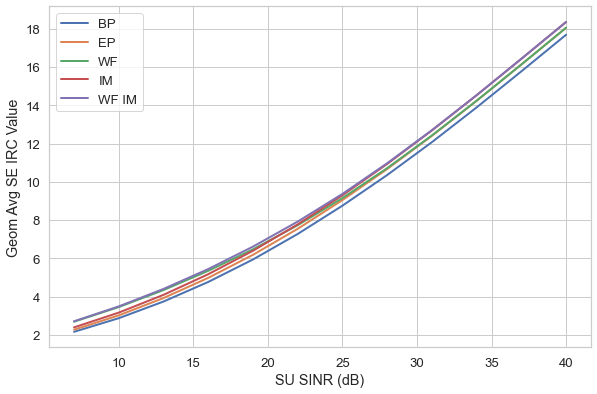

In [68]:
#history_mean[["ZF", "ZF EP", "ZF WF", 'ZF IM', "ZF WF IM"]].plot(lw=2, ylabel="Geom Avg SE IRC Value")
history_rzf_mean[["BP", "EP", "WF", 'IM', "WF IM"]].plot(lw=2, ylabel="Geom Avg SE IRC Value")
#plt.savefig("Images/PA_SE_IRC_Native_WF_RZF.pdf", bbox_inches='tight')

<ipython-input-69-fe312a4c69fb>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


[Text(0, -0.1, '-10%'),
 Text(0, -0.05, '-5%'),
 Text(0, 0.0, '0%'),
 Text(0, 0.05000000000000002, '5%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.15, '15%'),
 Text(0, 0.20000000000000004, '20%'),
 Text(0, 0.25, '25%')]

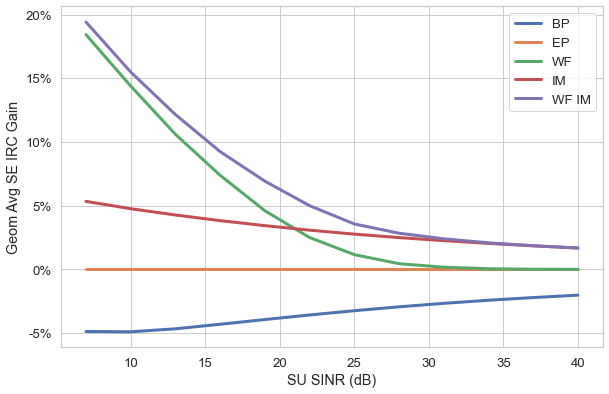

In [69]:
ax = ((history_rzf_mean[["BP", "EP", "WF", 'IM', "WF IM"]] / history_rzf_mean["EP"].values[:, None] - 1)).plot(lw=3, ylabel="Geom Avg SE IRC Gain")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
#plt.savefig("Images/PA_SE_IRC_WF_RZF.pdf", bbox_inches='tight')

<AxesSubplot:xlabel='SU SINR (dB)', ylabel='EESM SE IRC MCS Table 1 Value'>

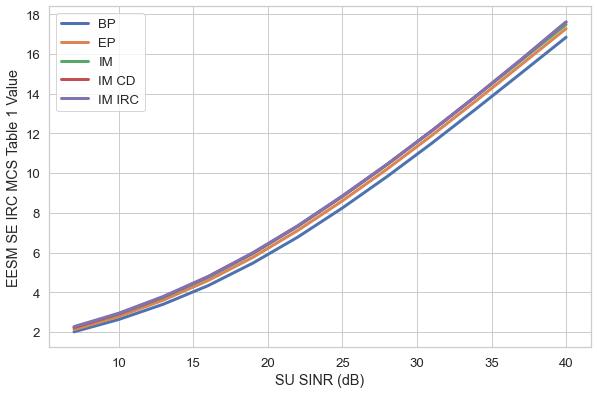

In [70]:
history_rzf_mean[["BP Table 1", "EP Table 1", "IM Table 1", "IM MCS CD Table 1", "IM MCS IRC Table 1"]].rename(columns={"BP Table 1":"BP", "EP Table 1":"EP", "IM Table 1":"IM",
                             "IM MCS CD Table 1":"IM CD", "IM MCS IRC Table 1":"IM IRC"}).plot(lw=3, ylabel="EESM SE IRC MCS Table 1 Value")
# manipulate
#plt.savefig("Images/PA_SE_Table_1_IRC_Native.pdf", bbox_inches='tight')

<ipython-input-74-6672edc757ad>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);


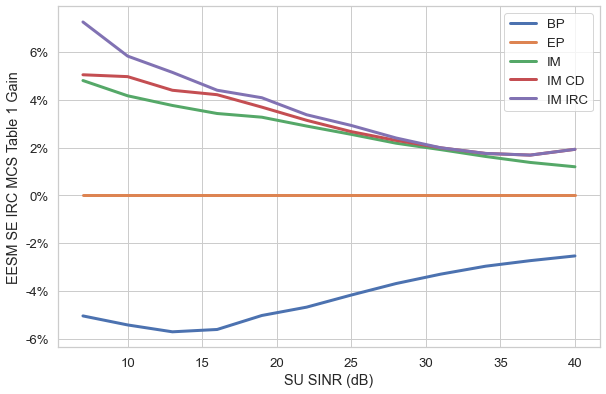

In [74]:
ax = ((history_rzf_mean[["BP Table 1", "EP Table 1", "IM Table 1", "IM MCS CD Table 1", "IM MCS IRC Table 1"]].rename(columns={"BP Table 1":"BP", "EP Table 1":"EP", "IM Table 1":"IM",
                             "IM MCS CD Table 1":"IM CD", "IM MCS IRC Table 1":"IM IRC"}) / history_rzf_mean["EP Table 1"].values[:, None] - 1)).plot(lw=3, ylabel="EESM SE IRC MCS Table 1 Gain")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
#plt.savefig("Images/PA_SE_Table_1_IRC.pdf", bbox_inches='tight')

<ipython-input-73-80ed6b3f6741>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);


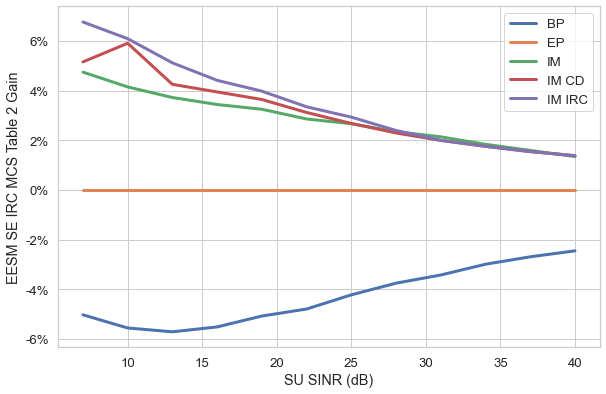

In [73]:
ax = ((history_rzf_mean[["BP Table 2", "EP Table 2", "IM Table 2", "IM MCS CD Table 2", "IM MCS IRC Table 2"]].rename(columns={"BP Table 2":"BP", "EP Table 2":"EP", "IM Table 2":"IM",
                             "IM MCS CD Table 2":"IM CD", "IM MCS IRC Table 2":"IM IRC"}) / history_rzf_mean["EP Table 2"].values[:, None] - 1)).plot(lw=3, ylabel="EESM SE IRC MCS Table 2 Gain")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
#plt.savefig("Images/PA_SE_Table_2_IRC.pdf", bbox_inches='tight')